In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import cluster, metrics
from random import sample
import matplotlib.pyplot as plt
from sklearn.preprocessing  import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
import pydotplus
from IPython.display import Image
import graphviz
from sklearn.linear_model  import LogisticRegression
from mlxtend.plotting import plot_confusion_matrix
import xgboost as xgb
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.feature_selection import f_regression

In [7]:
#read data and get dummy
# final_project = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/2 level train.csv", encoding = "ISO-8859-1")
# dummy_fields = final_project.columns[0:33].tolist()
# for each in dummy_fields:
#     dummies = pd.get_dummies(final_project.loc[:, each], prefix = each) 
#     final_project = pd.concat([final_project, dummies], axis = 1 )
# fields_to_drop = dummy_fields
# final_data = final_project.drop(fields_to_drop, axis = 1 )
# #reindex columns 
# reindex = final_data.columns[4:293].tolist()
# reindex.extend(['Year of Vehicle','Total Vehicles Involved','Difference between speed and average speed','Severity'])
# final_data = final_data.reindex(columns = reindex)
# final_data.to_csv('2 level train_dummy.csv')
# final_project = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/NJ17freeways 1.csv")
# final_project['Year of Vehicle'] = preprocessing.scale(final_project['Year of Vehicle'])
# final_project['Difference between speed and average speed'] = preprocessing.scale(final_project['Difference between speed and average speed'])
# final_project['Total Vehicles Involved'] = preprocessing.scale(final_project['Total Vehicles Involved'])
# final_project

## XGBoost 3 level

In [31]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):#largest_class_weight_coef找最大權重
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train) # 各class數量
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0) 
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}# 寫成集合
    class_weight_dict[classes[2]] = class_weight_dict[classes[2]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train] # 每個sample都要有weighted
    return sample_weights

In [28]:
# final_project = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/Final_clean_data.csv")
# final_project['Year of Vehicle'] = preprocessing.scale(final_project['Year of Vehicle'])
# final_project['Difference between speed and average speed'] = preprocessing.scale(final_project['Difference between speed and average speed'])
# final_project['Total Vehicles Involved'] = preprocessing.scale(final_project['Total Vehicles Involved'])
train = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/3 level train.csv")
train['Year of Vehicle'] = preprocessing.scale(train['Year of Vehicle'])
train['Difference between speed and average speed'] = preprocessing.scale(train['Difference between speed and average speed'])
train['Total Vehicles Involved'] = preprocessing.scale(train['Total Vehicles Involved'])
x_train = train.drop('Severity',axis=1)
y_train = train['Severity']
print(Counter(y_train ))

le = LabelEncoder()
for i in range(8):
    x_train.iloc[:,i] = le.fit_transform(x_train.iloc[:,i])
for i in range(34):
    x_train.iloc[:,i] = pd.Categorical(x_train.iloc[:,i])
x_train.iloc[:,34] = x_train.iloc[:,34].astype(int)
x_train.iloc[:,35] = x_train.iloc[:,35].astype(int)
y_train = pd.Categorical(y_train)
size_mapping = {'F':0, 'I':1, 'P':2}
y_train = y_train.map(size_mapping)
print(Counter(y_train))
print(Counter(y_test))

test = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/3 level test.csv")
final_project['Year of Vehicle'] = preprocessing.scale(final_project['Year of Vehicle'])
final_project['Difference between speed and average speed'] = preprocessing.scale(final_project['Difference between speed and average speed'])
final_project['Total Vehicles Involved'] = preprocessing.scale(final_project['Total Vehicles Involved'])
x_test = test.drop('Severity',axis=1)
y_test = test['Severity']
print(Counter(y_test))

le = LabelEncoder()
for i in range(8):
    x_test.iloc[:,i] = le.fit_transform(x_test.iloc[:,i])
for i in range(34):
    x_test.iloc[:,i] = pd.Categorical(x_test.iloc[:,i])
x_test.iloc[:,34] = x_test.iloc[:,34].astype(int)
x_test.iloc[:,35] = x_test.iloc[:,35].astype(int)
y_test = pd.Categorical(y_test)
size_mapping = {'F':0, 'I':1, 'P':2}
y_test = y_test.map(size_mapping)


d_train = xgb.DMatrix(data = np.array(x_train),label = np.array(y_train),feature_names=list(x_train))
d_test = xgb.DMatrix(data = np.array(x_test), label = np.array(y_test), feature_names=list(x_test))
params = {'booster': 'gbtree',
          'objective': 'multi:softmax',
          'num_class': 3,
          'learning_rate': 0.003,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'max_depth': 3,
          'min_child_weight': 3,
          'gamma': 0.1,
          'reg_alpha': 0.005,
          }
xgb_model = xgb.train(params, d_train, num_boost_round = 10)
preds_test = np.round(xgb_model.predict(d_test),0)
print("Not balanced","\n","confusion matrix :","\n",confusion_matrix(y_test,preds_test))
print("accuracy score: ",round(accuracy_score(y_test,preds_test),3))
fig,ax = plt.subplots(figsize=(15,15))
ax = plot_importance(xgb_model,
                     height=0.5,
                     ax=ax,
                     max_num_features=64)
plt.show()

#balanced
largest_class_weight_coef = max(y_train.value_counts().values)/y_train.shape[0]
weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)
d_train = xgb.DMatrix(data = np.array(x_train),label = np.array(y_train),feature_names=list(x_train),weight=weight)
d_test = xgb.DMatrix(data = np.array(x_test), label = np.array(y_test), feature_names=list(x_test))
params = {'booster': 'gbtree',
          'objective': 'multi:softmax',
          'num_class': 3,
          'learning_rate': 60.003,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'max_depth': 3,
          'min_child_weight': 3,
          'gamma': 0.1,
          'reg_alpha': 0.005,
          }
xgb_model = xgb.train(params, d_train, num_boost_round = 10)
preds_test = np.round(xgb_model.predict(d_test),0)
print("Balanced","\n","confusion matrix :","\n",confusion_matrix(y_test,preds_test))
print("accuracy score: ",round(accuracy_score(y_test,preds_test),3))
fig,ax = plt.subplots(figsize=(15,15))
ax = plot_importance(xgb_model,
                     height=0.5,
                     ax=ax,
                     max_num_features=64)
plt.show()
plt.savefig('XGB3level.png')

Counter({'P': 8615, 'I': 2524, 'F': 28})
Counter({2: 8615, 1: 2524, 0: 28})
Counter({2: 2177, 1: 603, 0: 13})
Counter({'P': 2177, 'I': 603, 'F': 13})
Not balanced 
 confusion matrix : 
 [[   0    4    9]
 [   0  116  487]
 [   0   79 2098]]
accuracy score:  0.793


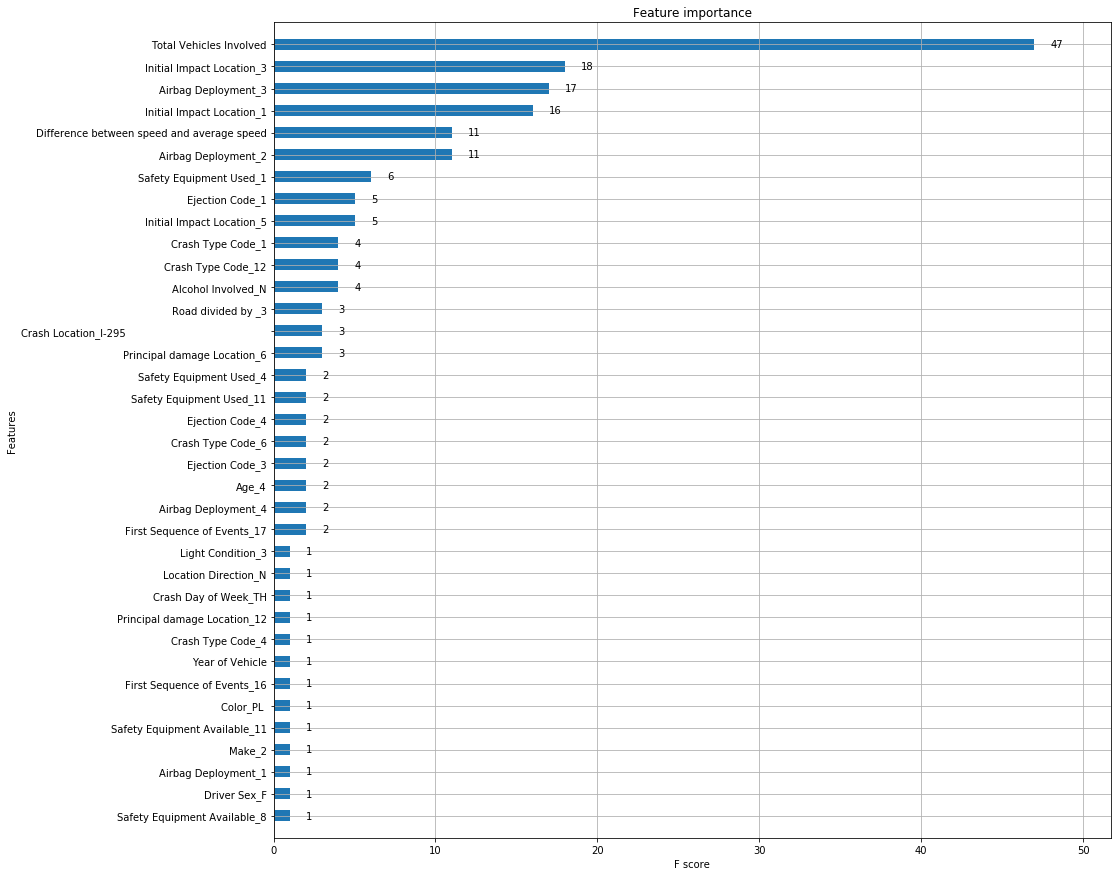

Balanced 
 confusion matrix : 
 [[   6    1    6]
 [ 172  251  180]
 [ 192 1533  452]]
accuracy score:  0.254


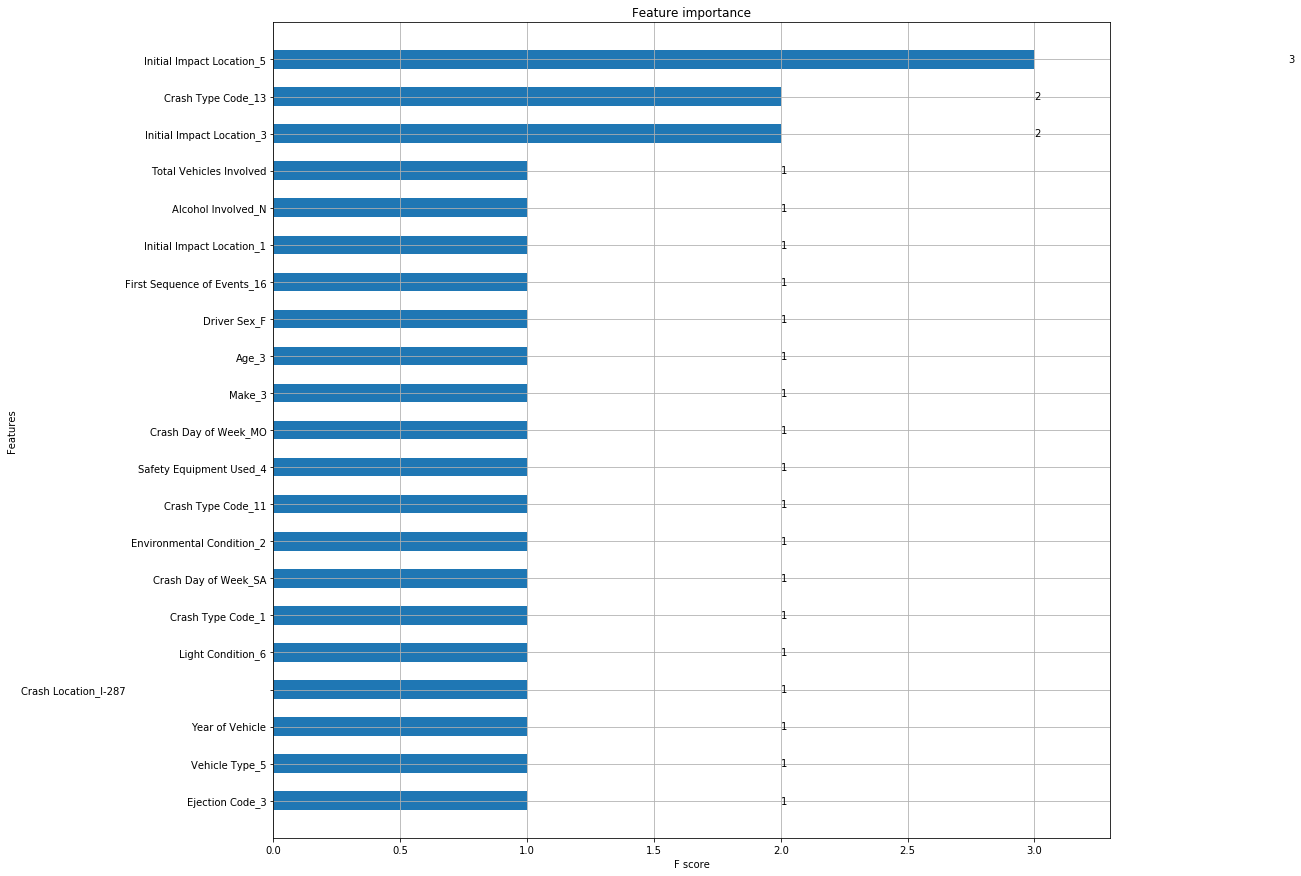

<Figure size 432x288 with 0 Axes>

In [32]:
# final_project = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/Final_clean_data.csv")
# final_project['Year of Vehicle'] = preprocessing.scale(final_project['Year of Vehicle'])
# final_project['Difference between speed and average speed'] = preprocessing.scale(final_project['Difference between speed and average speed'])
# final_project['Total Vehicles Involved'] = preprocessing.scale(final_project['Total Vehicles Involved'])
train = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/3 level train_dummy.csv")
train['Year of Vehicle'] = preprocessing.scale(train['Year of Vehicle'])
train['Difference between speed and average speed'] = preprocessing.scale(train['Difference between speed and average speed'])
train['Total Vehicles Involved'] = preprocessing.scale(train['Total Vehicles Involved'])
x_train = train.drop('Severity',axis=1)
y_train = train['Severity']
print(Counter(y_train ))
y_train = pd.Categorical(y_train)
size_mapping = {'F':0, 'I':1, 'P':2}
y_train = y_train.map(size_mapping)
print(Counter(y_train))
print(Counter(y_test))

test = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/3 level test_dummy.csv")
test['Year of Vehicle'] = preprocessing.scale(test['Year of Vehicle'])
test['Difference between speed and average speed'] = preprocessing.scale(test['Difference between speed and average speed'])
test['Total Vehicles Involved'] = preprocessing.scale(test['Total Vehicles Involved'])
x_test = test.drop('Severity',axis=1)
y_test = test['Severity']
print(Counter(y_test))
y_test = pd.Categorical(y_test)
size_mapping = {'F':0, 'I':1, 'P':2}
y_test = y_test.map(size_mapping)


d_train = xgb.DMatrix(data = np.array(x_train),label = np.array(y_train),feature_names=list(x_train))
d_test = xgb.DMatrix(data = np.array(x_test), label = np.array(y_test), feature_names=list(x_test))
params = {'booster': 'gbtree',
          'objective': 'multi:softmax',
          'num_class': 3,
          'learning_rate': 0.003,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'max_depth': 3,
          'min_child_weight': 3,
          'gamma': 0.1,
          'reg_alpha': 0.005,
          }
xgb_model = xgb.train(params, d_train, num_boost_round = 10)
preds_test = np.round(xgb_model.predict(d_test),0)
print("Not balanced","\n","confusion matrix :","\n",confusion_matrix(y_test,preds_test))
print("accuracy score: ",round(accuracy_score(y_test,preds_test),3))
fig,ax = plt.subplots(figsize=(15,15))
ax = plot_importance(xgb_model,
                     height=0.5,
                     ax=ax,
                     max_num_features=64)
plt.show()

#balanced
largest_class_weight_coef = max(y_train.value_counts().values)/y_train.shape[0]
weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)
d_train = xgb.DMatrix(data = np.array(x_train),label = np.array(y_train),feature_names=list(x_train),weight=weight)
d_test = xgb.DMatrix(data = np.array(x_test), label = np.array(y_test), feature_names=list(x_test))
params = {'booster': 'gbtree',
          'objective': 'multi:softmax',
          'num_class': 3,
          'learning_rate': 60.003,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'max_depth': 3,
          'min_child_weight': 3,
          'gamma': 0.1,
          'reg_alpha': 0.005,
          }
xgb_model = xgb.train(params, d_train, num_boost_round = 10)
preds_test = np.round(xgb_model.predict(d_test),0)
print("Balanced","\n","confusion matrix :","\n",confusion_matrix(y_test,preds_test))
print("accuracy score: ",round(accuracy_score(y_test,preds_test),3))
fig,ax = plt.subplots(figsize=(15,15))
ax = plot_importance(xgb_model,
                     height=0.5,
                     ax=ax,
                     max_num_features=64)
plt.show()
plt.savefig('XGB3level.png')

## XGBoost 2 level

Counter({'P': 8615, 'I': 2552})
Counter({1: 8615, 0: 2552})
Counter({2: 2177, 1: 603, 0: 13})
Counter({'P': 2177, 'I': 616})
Not balanced 
 confusion matrix : 
 [[  90  526]
 [  49 2128]]
accuracy score:  0.794


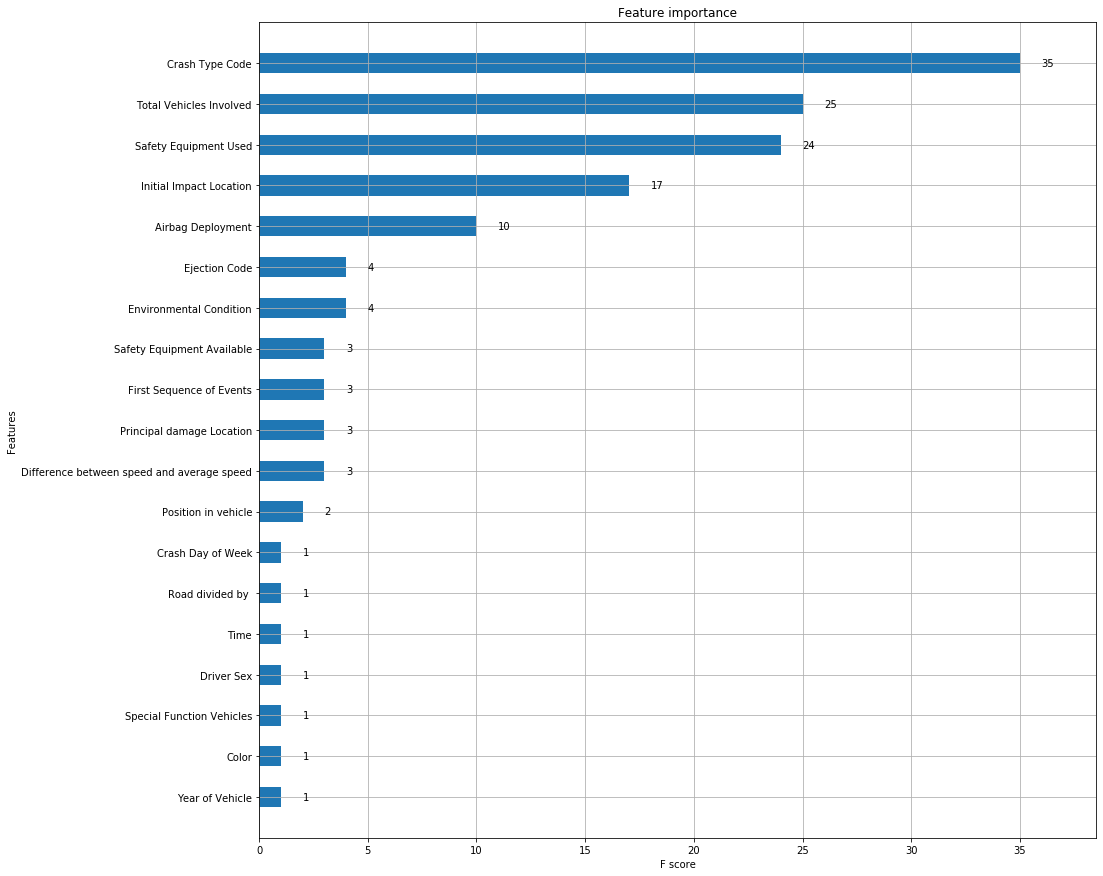

Balanced 
 confusion matrix : 
 [[ 440  176]
 [ 726 1451]]
accuracy score:  0.677


<Figure size 432x288 with 0 Axes>

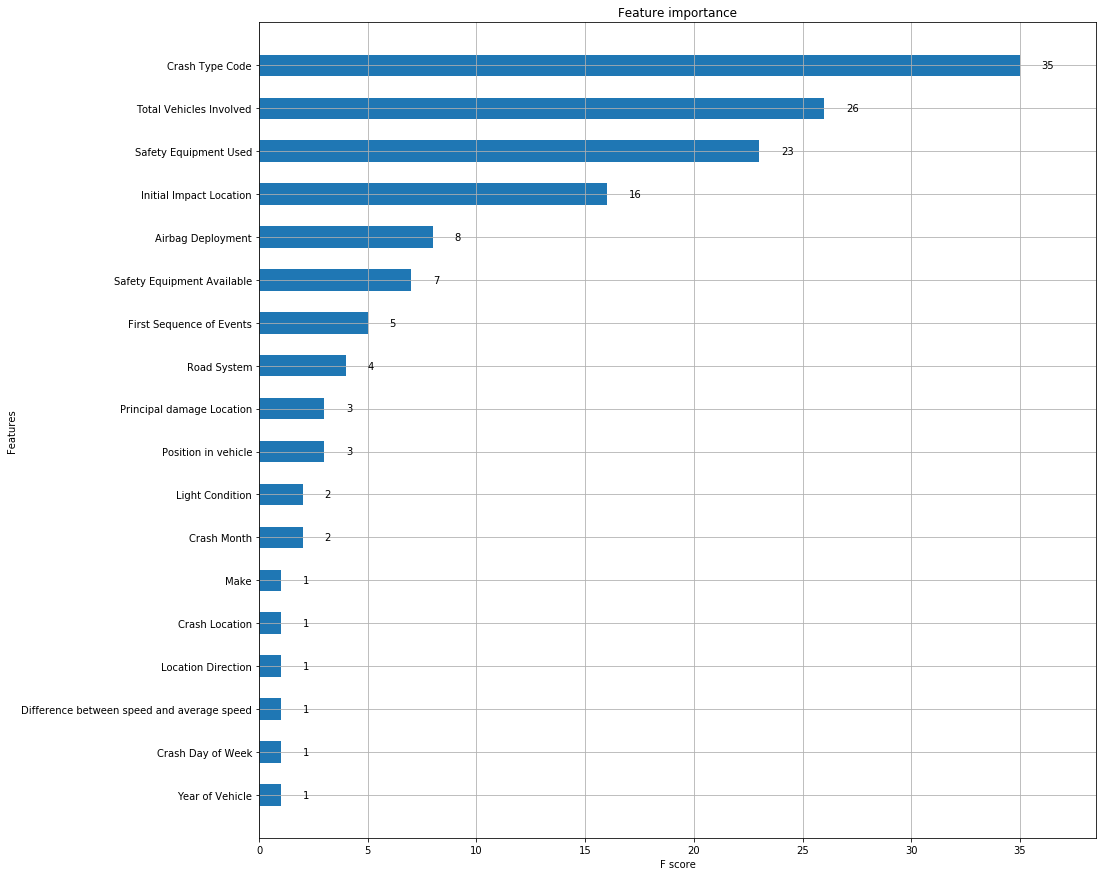

In [35]:
# final_project = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/Final_clean_data.csv")
# final_project['Year of Vehicle'] = preprocessing.scale(final_project['Year of Vehicle'])
# final_project['Difference between speed and average speed'] = preprocessing.scale(final_project['Difference between speed and average speed'])
# final_project['Total Vehicles Involved'] = preprocessing.scale(final_project['Total Vehicles Involved'])
train = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/2 level train.csv")
final_project['Year of Vehicle'] = preprocessing.scale(final_project['Year of Vehicle'])
final_project['Difference between speed and average speed'] = preprocessing.scale(final_project['Difference between speed and average speed'])
final_project['Total Vehicles Involved'] = preprocessing.scale(final_project['Total Vehicles Involved'])
x_train = train.drop('Severity',axis=1)
y_train = train['Severity']
print(Counter(y_train ))

le = LabelEncoder()
for i in range(8):
    x_train.iloc[:,i] = le.fit_transform(x_train.iloc[:,i])
for i in range(34):
    x_train.iloc[:,i] = pd.Categorical(x_train.iloc[:,i])
x_train.iloc[:,34] = x_train.iloc[:,34].astype(int)
x_train.iloc[:,35] = x_train.iloc[:,35].astype(int)
y_train = pd.Categorical(y_train)
size_mapping = { 'I':0, 'P':1}
y_train = y_train.map(size_mapping)
print(Counter(y_train))
print(Counter(y_test))

test = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/2 level test.csv")
final_project['Year of Vehicle'] = preprocessing.scale(final_project['Year of Vehicle'])
final_project['Difference between speed and average speed'] = preprocessing.scale(final_project['Difference between speed and average speed'])
final_project['Total Vehicles Involved'] = preprocessing.scale(final_project['Total Vehicles Involved'])
x_test = test.drop('Severity',axis=1)
y_test = test['Severity']
print(Counter(y_test))

le = LabelEncoder()
for i in range(8):
    x_test.iloc[:,i] = le.fit_transform(x_test.iloc[:,i])
for i in range(34):
    x_test.iloc[:,i] = pd.Categorical(x_test.iloc[:,i])
x_test.iloc[:,34] = x_test.iloc[:,34].astype(int)
x_test.iloc[:,35] = x_test.iloc[:,35].astype(int)
y_test = pd.Categorical(y_test)
size_mapping = { 'I':0, 'P':1}
y_test = y_test.map(size_mapping)


d_train = xgb.DMatrix(data = np.array(x_train),label = np.array(y_train),feature_names=list(x_train))
d_test = xgb.DMatrix(data = np.array(x_test), label = np.array(y_test), feature_names=list(x_test))
params = {'booster': 'gbtree',
          'objective': 'multi:softmax',
          'num_class': 3,
          'learning_rate': 0.003,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'max_depth': 3,
          'min_child_weight': 3,
          'gamma': 0.1,
          'reg_alpha': 0.005,
          }
xgb_model = xgb.train(params, d_train, num_boost_round = 10)
preds_test = np.round(xgb_model.predict(d_test),0)
print("Not balanced","\n","confusion matrix :","\n",confusion_matrix(y_test,preds_test))
print("accuracy score: ",round(accuracy_score(y_test,preds_test),3))
fig,ax = plt.subplots(figsize=(15,15))
ax = plot_importance(xgb_model,
                     height=0.5,
                     ax=ax,
                     max_num_features=64)
plt.show()
plt.savefig('XGB2level.png')
#balanced
largest_class_weight_coef = max(y_train.value_counts().values)/y_train.shape[0]
weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)
d_train = xgb.DMatrix(data = np.array(x_train),label = np.array(y_train),feature_names=list(x_train),weight=weight)
d_test = xgb.DMatrix(data = np.array(x_test), label = np.array(y_test), feature_names=list(x_test))
params = {'booster': 'gbtree',
          'objective': 'multi:softmax',
          'num_class': 3,
          'learning_rate': 0.003,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'max_depth': 3,
          'min_child_weight': 3,
          'gamma': 0.1,
          'reg_alpha': 0.005,
          }
xgb_model = xgb.train(params, d_train, num_boost_round = 10)
preds_test = np.round(xgb_model.predict(d_test),0)
print("Balanced","\n","confusion matrix :","\n",confusion_matrix(y_test,preds_test))
print("accuracy score: ",round(accuracy_score(y_test,preds_test),3))
fig,ax = plt.subplots(figsize=(15,15))
ax = plot_importance(xgb_model,
                     height=0.5,
                     ax=ax,
                     max_num_features=64)
plt.show()

## Logistic regression 3 level

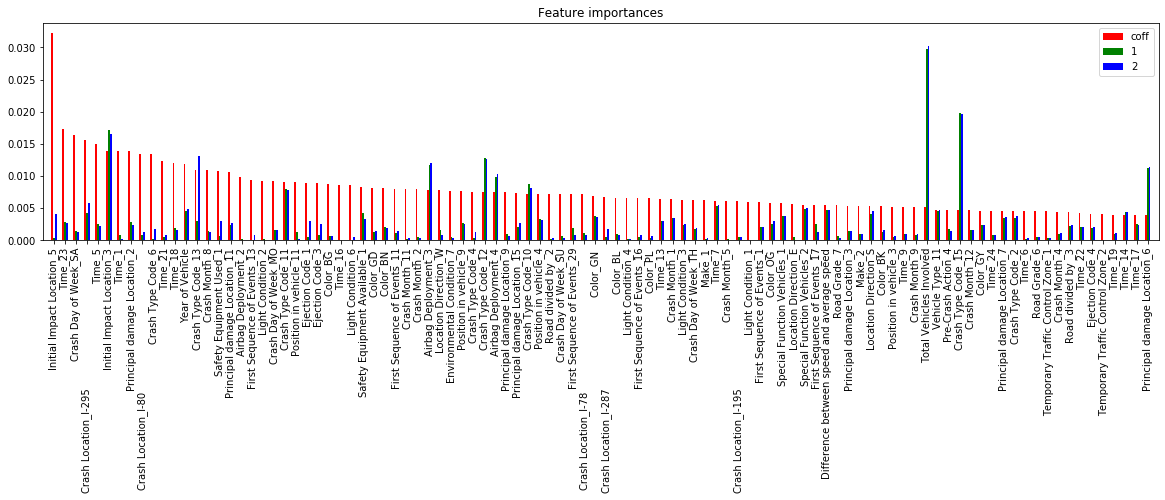

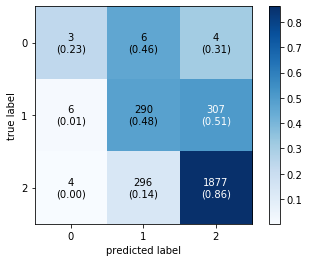

accuracy score:  0.777


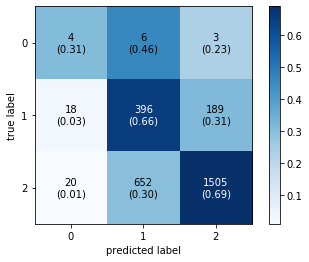

accuracy score:  0.682


In [17]:
train = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/3 level train_dummy.csv")
final_project['Year of Vehicle'] = preprocessing.scale(final_project['Year of Vehicle'])
final_project['Difference between speed and average speed'] = preprocessing.scale(final_project['Difference between speed and average speed'])
final_project['Total Vehicles Involved'] = preprocessing.scale(final_project['Total Vehicles Involved'])
x_train = train.drop('Severity',axis=1)
y_train = train['Severity']

test = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/3 level test_dummy.csv")
final_project['Year of Vehicle'] = preprocessing.scale(final_project['Year of Vehicle'])
final_project['Difference between speed and average speed'] = preprocessing.scale(final_project['Difference between speed and average speed'])
final_project['Total Vehicles Involved'] = preprocessing.scale(final_project['Total Vehicles Involved'])
x_test = test.drop('Severity',axis=1)
y_test = test['Severity']


sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
lr.fit(x_train_nor,y_train)

feature_importance=pd.DataFrame(lr.coef_)
feature_importance.columns=x_train.columns
a=abs(feature_importance.T)
a.rename(columns = {0: "coff"},inplace = True)
Sort=a.sort_values(by='coff',ascending=False)
Percent_S=Sort/sum(Sort['coff'])
Percent_S.head(100).plot.bar(figsize=(20,4),color='rgbycmg')#V15[52] The 53rd columns
plt.title("Feature importances")
plt.xlim((-1, 100))

labels=['F','I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#balanced
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
lr.fit(x_train_nor,y_train)

labels=['F','I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

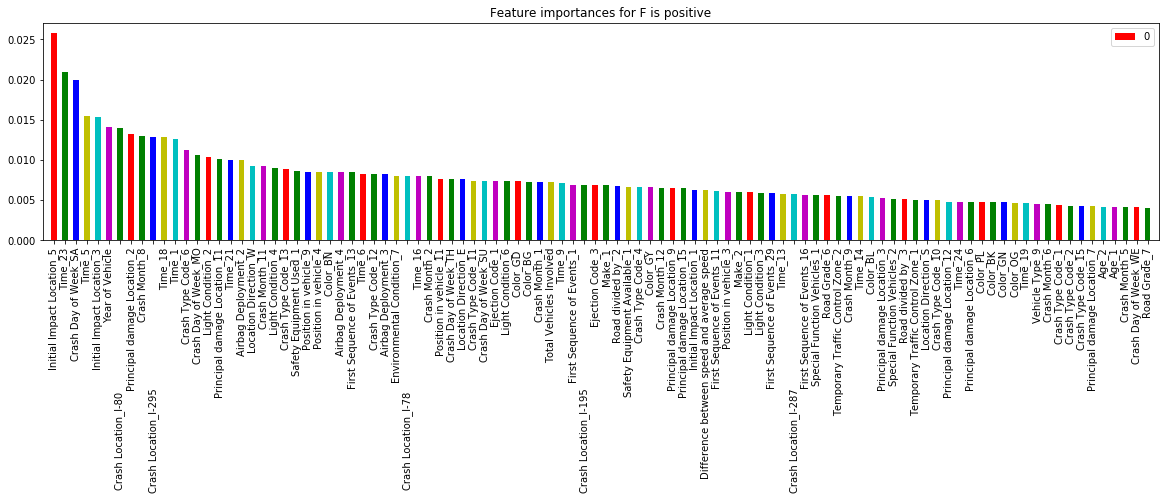

In [18]:
feature_importance=pd.DataFrame(lr.coef_)
feature_importance.columns=x_train.columns
a=abs(feature_importance.T)
Sort=a.sort_values(by=0,ascending=False)
Percent_S=pd.DataFrame(Sort[0]/sum(Sort[0]))
Percent_S.head(100).plot.bar(figsize=(20,4),color='rgbycmg')#V15[52] The 53rd columns
plt.title("Feature importances for F is positive")
plt.xlim((-1, 100))
plt.savefig("Feature importances for F is positive.png")

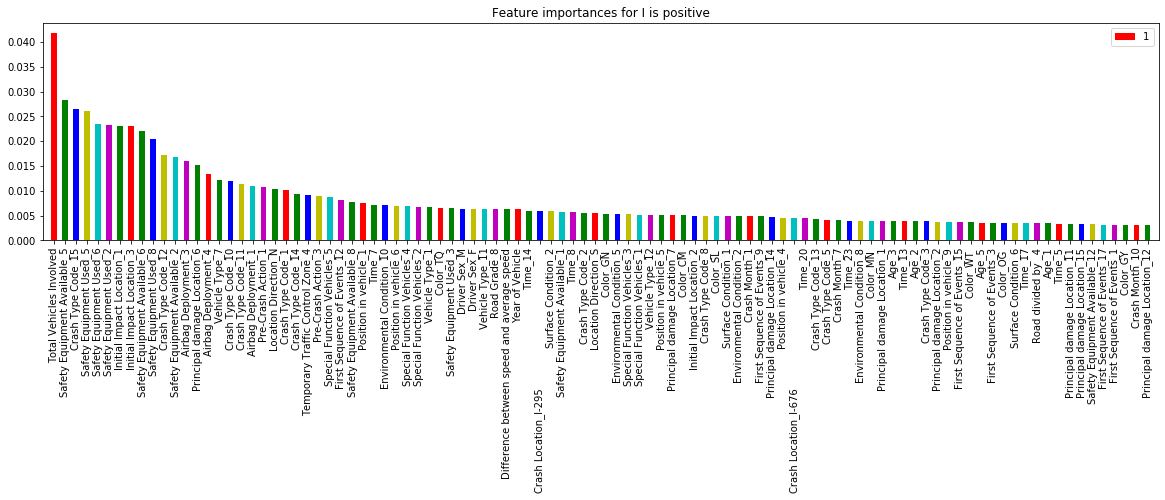

In [19]:
feature_importance=pd.DataFrame(lr.coef_)
feature_importance.columns=x_train.columns
a=abs(feature_importance.T)
Sort=a.sort_values(by=1,ascending=False)
Percent_S=pd.DataFrame(Sort[1]/sum(Sort[1]))
Percent_S.head(100).plot.bar(figsize=(20,4),color='rgbycmg')#V15[52] The 53rd columns
plt.title("Feature importances for I is positive")
plt.xlim((-1, 100))
plt.savefig("Feature importances for I is positive.png")

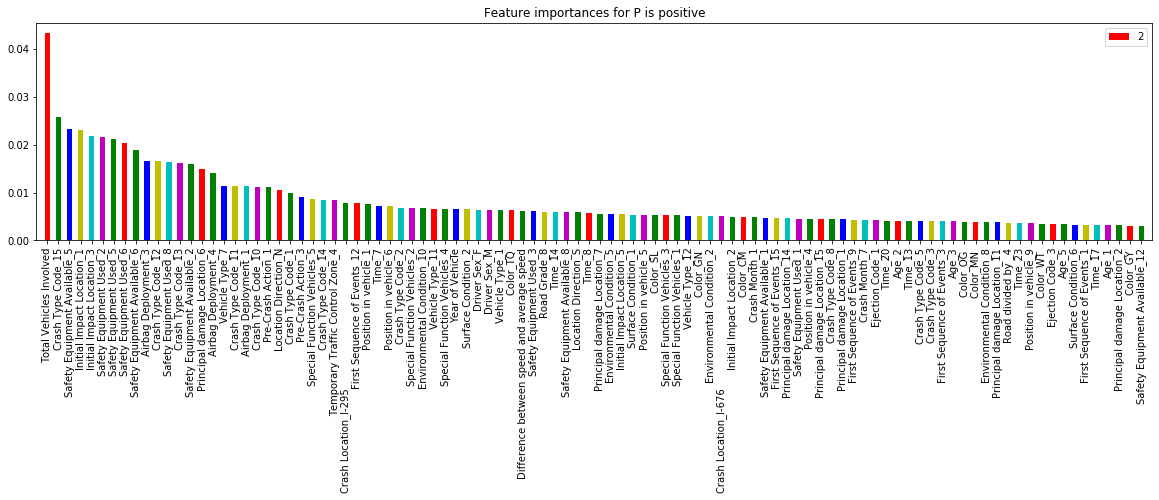

In [20]:
feature_importance=pd.DataFrame(lr.coef_)
feature_importance.columns=x_train.columns
a=abs(feature_importance.T)
Sort=a.sort_values(by=2,ascending=False)
Percent_S=pd.DataFrame(Sort[2]/sum(Sort[2]))
Percent_S.head(100).plot.bar(figsize=(20,4),color='rgbycmg')#V15[52] The 53rd columns
plt.title("Feature importances for P is positive")
plt.xlim((-1, 100))
plt.savefig("Feature importances for P is positive.png")

## Logistic regression 2 level

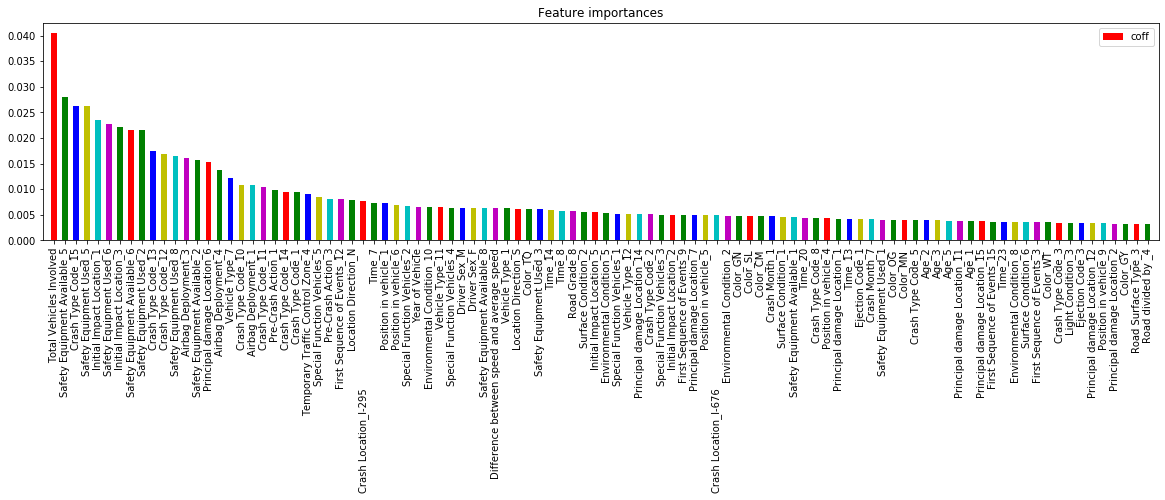

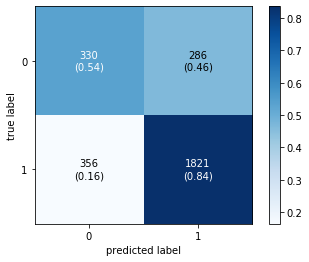

accuracy score:  0.77


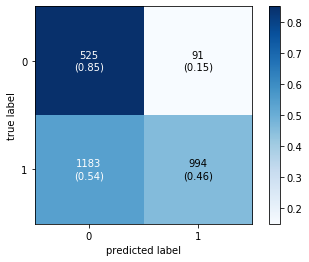

accuracy score:  0.544


In [22]:
train = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/2 level train_dummy.csv")
final_project['Year of Vehicle'] = preprocessing.scale(final_project['Year of Vehicle'])
final_project['Difference between speed and average speed'] = preprocessing.scale(final_project['Difference between speed and average speed'])
final_project['Total Vehicles Involved'] = preprocessing.scale(final_project['Total Vehicles Involved'])
x_train = train.drop('Severity',axis=1)
y_train = train['Severity']

test = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/2 level test_dummy.csv")
final_project['Year of Vehicle'] = preprocessing.scale(final_project['Year of Vehicle'])
final_project['Difference between speed and average speed'] = preprocessing.scale(final_project['Difference between speed and average speed'])
final_project['Total Vehicles Involved'] = preprocessing.scale(final_project['Total Vehicles Involved'])
x_test = test.drop('Severity',axis=1)
y_test = test['Severity']


sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
lr.fit(x_train_nor,y_train)

feature_importance=pd.DataFrame(lr.coef_)
feature_importance.columns=x_train.columns
a=abs(feature_importance.T)
a.rename(columns = {0: "coff"},inplace = True)
Sort=a.sort_values(by='coff',ascending=False)
Percent_S=Sort/sum(Sort['coff'])
Percent_S.head(100).plot.bar(figsize=(20,4),color='rgbycmg')#V15[52] The 53rd columns
plt.title("Feature importances")
plt.xlim((-1, 100))

labels=['I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#balanced
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
lr.fit(x_train_nor,y_train)

labels=['I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

## Decision tree 3 level

Counter({'P': 10966, 'I': 3170, 'F': 40})
Counter({'P': 8748, 'I': 2564, 'F': 28})
Counter({'P': 2218, 'I': 606, 'F': 12})
Not balanced 
 confusion matrix : 
 [[   0    5    7]
 [   0  134  472]
 [   0  124 2094]]
accuracy: 0.7856135401974612

Balanced 
 confusion matrix : 
 [[  10    1    1]
 [  28  325  253]
 [  52  535 1631]]
accuracy: 0.6932299012693935


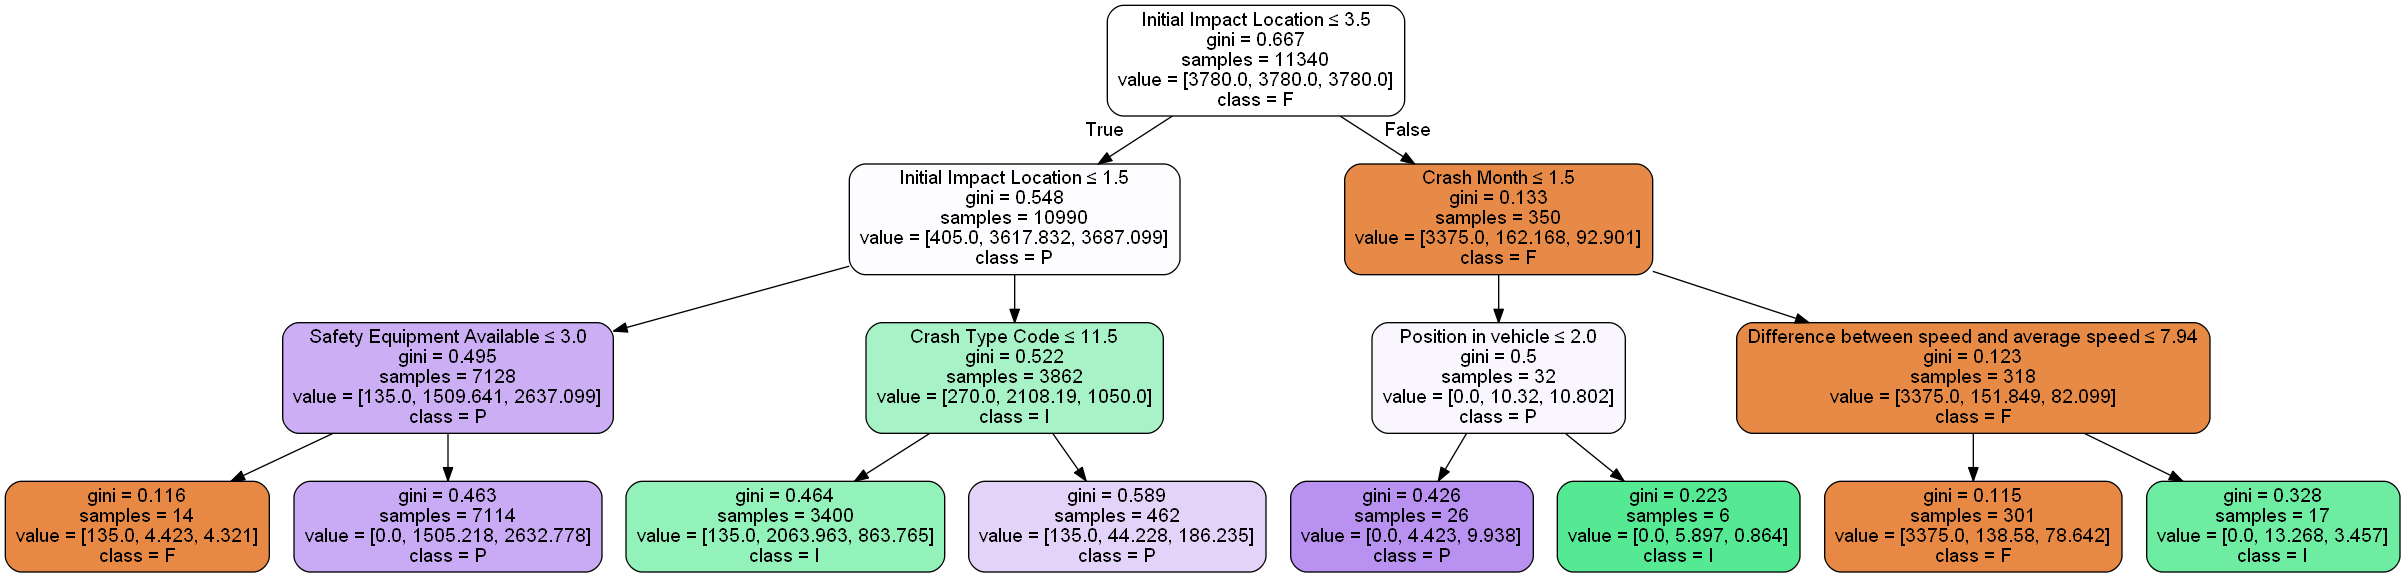

In [77]:
# #DT 3_level
# final_project = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/NJ17freeways 1.csv")
# print(Counter(final_project['Severity'] ))
# le = LabelEncoder()
# for i in range(8):
#     final_project.iloc[:,i] = le.fit_transform(final_project.iloc[:,i])
# for i in range(34):
#     final_project.iloc[:,i] = pd.Categorical(final_project.iloc[:,i])
# final_project.iloc[:,33] = final_project.iloc[:,33].astype(int)
# final_project.iloc[:,34] = final_project.iloc[:,34].astype(int)
# final_project.iloc[:,36] = pd.Categorical(final_project.iloc[:,36])
# # final_project.info()
# X = final_project.drop('Severity',axis = 1)
# Y = final_project['Severity']
# train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size = 0.2, random_state = 20200608)
# clf = tree.DecisionTreeClassifier(max_depth = 3) #not alanced
# data_clf = clf.fit(train_X, train_y)
# test_y_predicted = data_clf.predict(test_X)
# print(Counter(train_y))
# print(Counter(test_y))
# print("Not balanced","\n","confusion matrix :","\n",confusion_matrix(test_y,test_y_predicted))
# print("accuracy:",clf.score(test_X,test_y))
# label_name  = ['F','I','P']
# dot_data = tree.export_graphviz(clf, out_file=None, feature_names=train_X.columns, class_names=label_name, filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())
# # graph.write_pdf("final_3 level not balanced.pdf")

# #balanced
# clf = tree.DecisionTreeClassifier(max_depth = 3,class_weight = 'balanced') #balanced
# data_clf = clf.fit(train_X, train_y)
# test_y_predicted = data_clf.predict(test_X)
# Counter(test_y)
# print("")
# print("Balanced","\n","confusion matrix :","\n",confusion_matrix(test_y,test_y_predicted))
# print("accuracy:",clf.score(test_X,test_y))
# dot_data = tree.export_graphviz(clf, out_file=None, feature_names=train_X.columns, class_names=label_name, filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data)

# Image(graph.create_png())
# # graph.write_pdf("final_3 level balanced.pdf")

In [4]:
# label_name  = ['F','I','P']
# clf = tree.DecisionTreeClassifier(max_depth = 3,class_weight = 'balanced') #balanced
# data_clf = clf.fit(X, Y)
# test_y_predicted = data_clf.predict(X)
# dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, class_names=label_name, filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf("final_3 level balanced LR.pdf")
# print(Counter(data_clf.apply(X))) # leaf data position
# Image(graph.create_png())

In [10]:
final_project.columns[0:33]
new_data = final_project
node = [2,5,7,9,10,12,14,15]
node_2 = (new_data[new_data['position'] == 2]).drop(['Initial.Impact.Location'],axis = 1)
node_2 = node_2.drop('position',axis = 1)

,Crash.Day.of.Week,Alcohol.Involved,Hazmat.Involved,Crash.Location,Location.Direction,Color,Cell.phone.in.use,Driver.Sex,Crash.Month,Time,...,Ejection.Code,Safety.Equipment.Available,Safety.Equipment.Used,Airbag.Deployment,Age,Year.of.Vehicle,Total.Vehicles.Involved,Difference.between.speed.and.average.speed,Severity,position
0,SU,Y,N,I-295 ...,N,BG,N,M,6,21,...,4,11,11,1,3,16,1,2.99,F,2
2,WE,N,N,I-195 ...,W,BK,N,M,3,4,...,1,11,11,4,3,13,2,-4.47,F,2
3,WE,N,N,I-295 ...,N,RD,N,M,12,6,...,3,11,1,3,3,4,2,-44.25,F,2
4,SU,N,N,I-295 ...,N,BL,N,M,5,23,...,1,11,1,4,1,3,1,7.44,F,2
5,SU,N,N,I-295 ...,N,RD,N,M,9,7,...,1,11,1,4,2,16,2,-19.34,F,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13681,TU,N,N,I-78 ...,E,GY,N,M,10,7,...,1,11,4,3,2,6,2,-5.35,P,2
13729,TU,N,N,I-295 ...,N,BK,N,F,12,17,...,1,11,4,3,2,21,1,-3.13,P,2
13770,SA,Y,N,I-295 ...,S,BK,N,M,7,21,...,1,11,11,2,3,4,1,-16.01,P,2
13928,TH,N,N,I-295 ...,N,SL,N,F,9,3,...,1,11,11,1,2,7,1,2.06,P,2


node_2 :


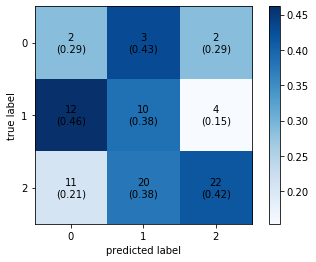

accuracy score:  0.395
node_5 :


C:\Users\saes0\Anaconda3\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:66: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


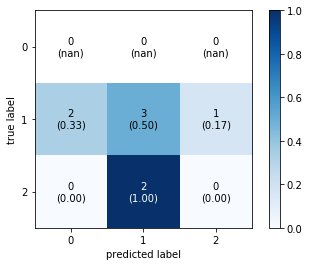

accuracy score:  0.375
node_7 :


C:\Users\saes0\Anaconda3\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:66: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


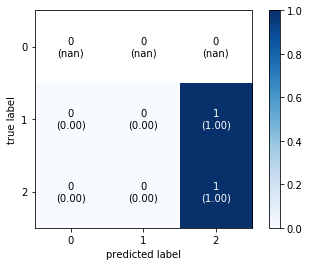

accuracy score:  0.5
node_9 :


C:\Users\saes0\Anaconda3\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:66: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


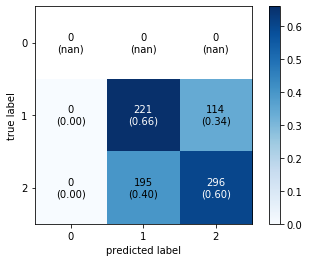

accuracy score:  0.626
node_10 :


C:\Users\saes0\Anaconda3\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:66: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


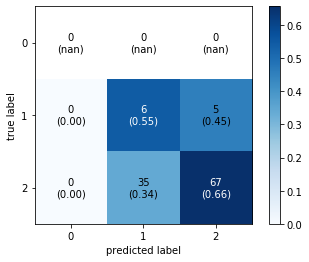

accuracy score:  0.646
node_12 :


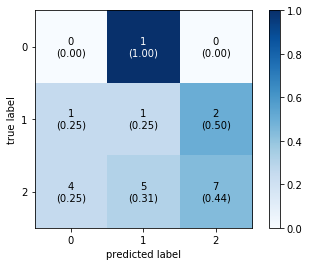

accuracy score:  0.381
node_14 :


C:\Users\saes0\Anaconda3\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:66: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


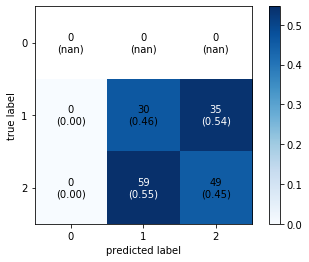

accuracy score:  0.457
node_15 :


C:\Users\saes0\Anaconda3\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:66: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


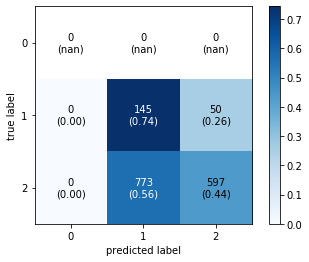

accuracy score:  0.474


In [13]:
# X['position'] = data_clf.apply(X)
# new_data = X
final_project = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/three_level_data.csv")
new_data = final_project
node = [2,5,7,9,10,12,14,15]
node_2 = (new_data[new_data['position'] == 2]).drop(['Initial.Impact.Location'],axis = 1)
node_2 = node_2.drop('position',axis = 1)
node_5 = (new_data[new_data['position'] == 5]).drop(['Initial.Impact.Location','Ejection.Code'],axis = 1)
node_5 = node_5.drop('position',axis = 1)
node_7 = (new_data[new_data['position'] == 7]).drop(['Ejection.Code','Initial.Impact.Location','Crash.Type.Code'],axis = 1)
node_7 = node_7.drop('position',axis = 1)
node_9 = (new_data[new_data['position'] == 9]).drop(['Ejection.Code','Initial.Impact.Location','Crash.Type.Code'],axis = 1)
node_9 = node_9.drop('position',axis = 1)
node_10= (new_data[new_data['position'] == 10]).drop(['Ejection.Code','Initial.Impact.Location','Crash.Type.Code'],axis = 1)
node_10 = node_10.drop('position',axis = 1)
node_12= (new_data[new_data['position'] == 12]).drop(['Initial.Impact.Location','Safety.Equipment.Used'],axis = 1)
node_12 = node_12.drop('position',axis = 1)
node_14= (new_data[new_data['position'] == 14]).drop(['Initial.Impact.Location','Safety.Equipment.Used','Total.Vehicles.Involved'],axis = 1)
node_14 = node_14.drop('position',axis = 1)
node_15= (new_data[new_data['position'] == 15]).drop(['Initial.Impact.Location','Safety.Equipment.Used','Total.Vehicles.Involved'],axis = 1)
node_15 = node_15.drop('position',axis = 1)

#node2
print("node_2 :")
dummy_fields = node_2.columns[0:32].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_2.loc[:, each], prefix = each) 
    node_2 = pd.concat([node_2, dummies], axis = 1 )
fields_to_drop = dummy_fields
node2 = node_2.drop(fields_to_drop, axis = 1 )
x = node2.drop('Severity',axis = 1)
y = node2['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['F','I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node5
print("node_5 :")
dummy_fields = node_5.columns[0:31].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_5.loc[:, each], prefix = each) 
    node_5 = pd.concat([node_5, dummies], axis = 1 )
fields_to_drop = dummy_fields
node5 = node_5.drop(fields_to_drop, axis = 1 )
x = node5.drop('Severity',axis = 1)
y = node5['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['F','I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node7
print("node_7 :")
dummy_fields = node_7.columns[0:30].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_7.loc[:, each], prefix = each) 
    node_7 = pd.concat([node_7, dummies], axis = 1 )
fields_to_drop = dummy_fields
node7 = node_7.drop(fields_to_drop, axis = 1 )
x = node7.drop('Severity',axis = 1)
y = node7['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['F','I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node9
print("node_9 :")
dummy_fields = node_9.columns[0:30].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_9.loc[:, each], prefix = each) 
    node_9 = pd.concat([node_9, dummies], axis = 1 )
fields_to_drop = dummy_fields
node9 = node_9.drop(fields_to_drop, axis = 1 )
x = node9.drop('Severity',axis = 1)
y = node9['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['F','I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node10
print("node_10 :")
dummy_fields = node_10.columns[0:30].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_10.loc[:, each], prefix = each) 
    node_10 = pd.concat([node_10, dummies], axis = 1 )
fields_to_drop = dummy_fields
node10 = node_10.drop(fields_to_drop, axis = 1 )
x = node10.drop('Severity',axis = 1)
y = node10['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['F','I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node12
print("node_12 :")
dummy_fields = node_12.columns[0:31].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_12.loc[:, each], prefix = each) 
    node_12 = pd.concat([node_12, dummies], axis = 1 )
fields_to_drop = dummy_fields
node12 = node_12.drop(fields_to_drop, axis = 1 )
x = node12.drop('Severity',axis = 1)
y = node12['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['F','I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node14
print("node_14 :")
dummy_fields = node_14.columns[0:31].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_14.loc[:, each], prefix = each) 
    node_14 = pd.concat([node_14, dummies], axis = 1 )
fields_to_drop = dummy_fields
node14 = node_14.drop(fields_to_drop, axis = 1 )
x = node14.drop('Severity',axis = 1)
y = node14['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['F','I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node15
print("node_15 :")
dummy_fields = node_15.columns[0:31].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_15.loc[:, each], prefix = each) 
    node_15 = pd.concat([node_15, dummies], axis = 1 )
fields_to_drop = dummy_fields
node15 = node_15.drop(fields_to_drop, axis = 1 )
x = node15.drop('Severity',axis = 1)
y = node15['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['F','I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))


## Decision tree 2 level

Counter({'P': 10966, 'I': 3210})
Counter({'P': 8748, 'I': 2592})
Counter({'P': 2218, 'I': 618})
Not balanced 
 confusion matrix : 
 [[ 139  479]
 [ 124 2094]]
accuracy: 0.78737658674189
Balanced 
 confusion matrix : 
 [[ 412  206]
 [ 695 1523]]
accuracy: 0.6822990126939351


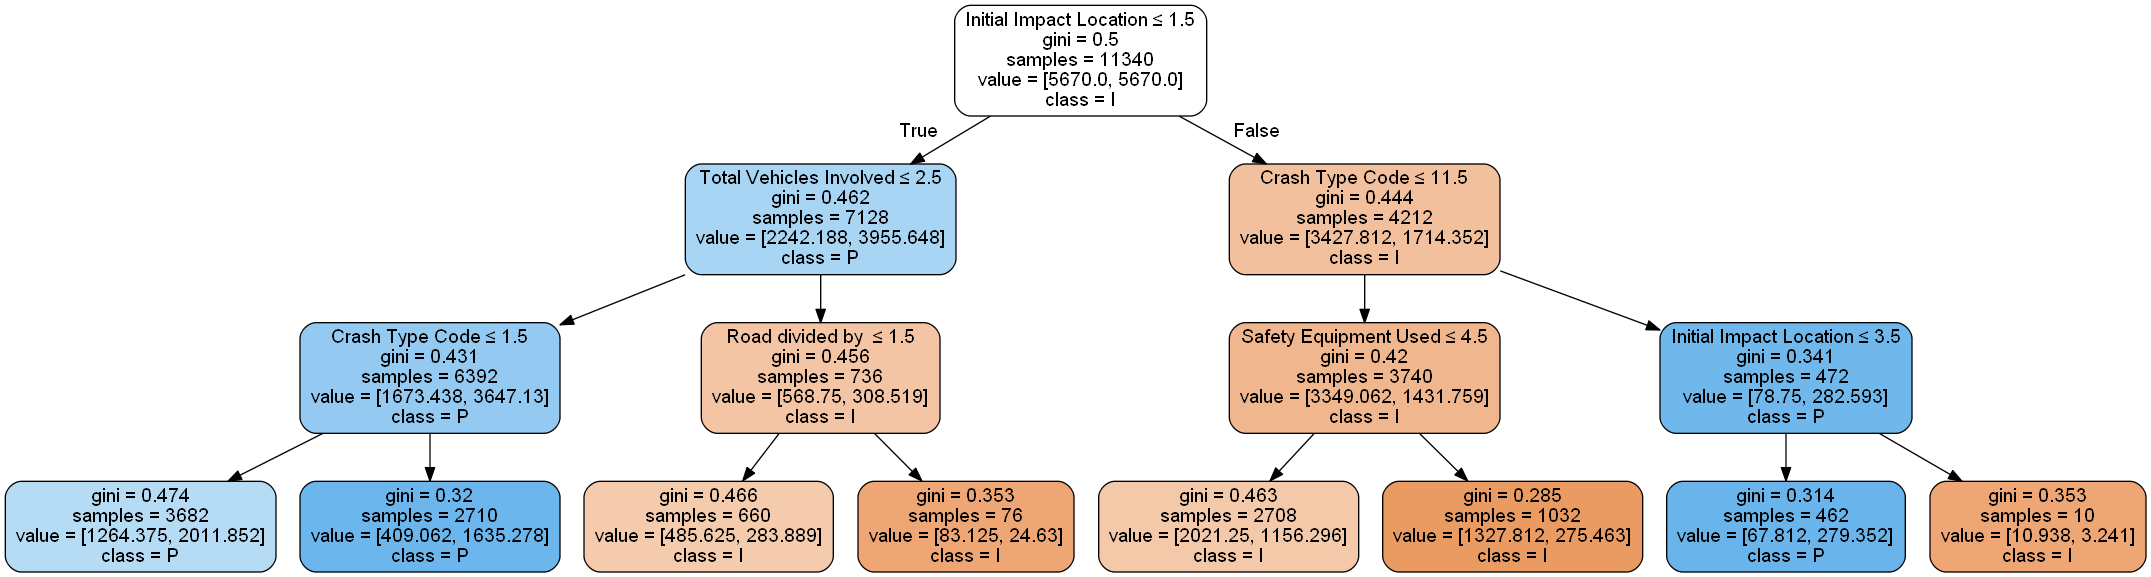

In [82]:
# #DT 2_level
# final_project = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/NJ17freeways 1.csv")
# final_project['Severity'] = final_project['Severity'].str.replace("F","I")
# print(Counter(final_project['Severity'] ))
# le = LabelEncoder()
# for i in range(8):
#     final_project.iloc[:,i] = le.fit_transform(final_project.iloc[:,i])
# for i in range(34):
#     final_project.iloc[:,i] = pd.Categorical(final_project.iloc[:,i])
# final_project.iloc[:,34] = final_project.iloc[:,34].astype(int)
# final_project.iloc[:,36] = pd.Categorical(final_project.iloc[:,36])
# # final_project.info()
# X = final_project.drop('Severity',axis = 1)
# Y = final_project['Severity']
# train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size = 0.2, random_state = 20200608)
# clf = tree.DecisionTreeClassifier(max_depth = 3) #not alanced
# data_clf = clf.fit(train_X, train_y)
# test_y_predicted = data_clf.predict(test_X)
# print(Counter(train_y))
# print(Counter(test_y))
# print("Not balanced","\n","confusion matrix :","\n",confusion_matrix(test_y,test_y_predicted))
# print("accuracy:",clf.score(test_X,test_y))
# label_name  = ['I','P']
# dot_data = tree.export_graphviz(clf, out_file=None, feature_names=train_X.columns, class_names=label_name, filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())
# # graph.write_pdf("final_2 level not balanced.pdf")

# #balanced
# clf = tree.DecisionTreeClassifier(max_depth = 3,class_weight = 'balanced') #balanced
# data_clf = clf.fit(train_X, train_y)
# test_y_predicted = data_clf.predict(test_X)
# Counter(test_y)
# print("Balanced","\n","confusion matrix :","\n",confusion_matrix(test_y,test_y_predicted))
# print("accuracy:",clf.score(test_X,test_y))
# dot_data = tree.export_graphviz(clf, out_file=None, feature_names=train_X.columns, class_names=label_name, filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())
# # graph.write_pdf("final_2 level balanced.pdf")

In [15]:
# label_name  = ['I','P']
# clf = tree.DecisionTreeClassifier(max_depth = 3,class_weight = None) 
# data_clf = clf.fit(X, Y)
# test_y_predicted = data_clf.predict(X)
# dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, class_names=label_name, filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf("final_2 level non-balanced LR.pdf")
# print(Counter(data_clf.apply(X))) # leaf data position
# Image(graph.create_png())

node_3 :


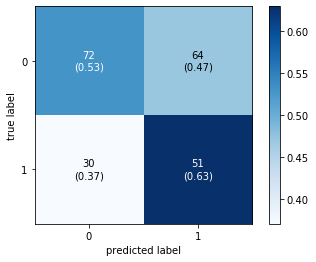

accuracy score:  0.567
node_4 :


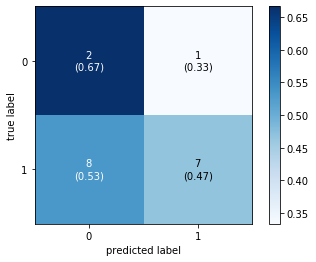

accuracy score:  0.5
node_8 :


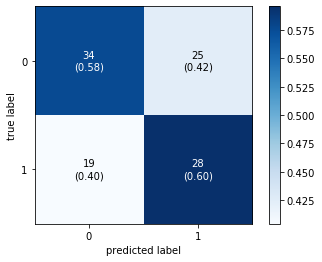

accuracy score:  0.585
node_9 :


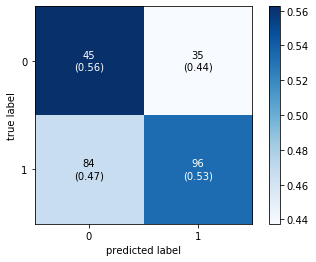

accuracy score:  0.542
node_10 :


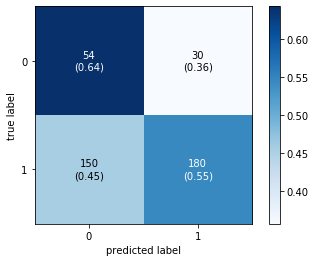

accuracy score:  0.565
node_11 :


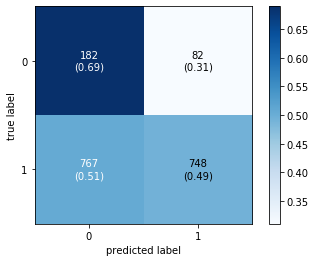

accuracy score:  0.523


In [25]:
# X['position'] = data_clf.apply(X)
# new_data = X
final_project = pd.read_csv("C:/Users/saes0/Desktop/台大/資料分析/two_level_data.csv")
new_data = final_project
node = [3,4,8,9,10,11]
node_3 = (new_data[new_data['position'] == 3]).drop(['Airbag.Deployment','Crash.Type.Code'],axis = 1)
node_3 = node_3.drop('position',axis = 1)
node_4 = (new_data[new_data['position'] == 4]).drop(['Airbag.Deployment','Crash.Type.Code'],axis = 1)
node_4 = node_4.drop('position',axis = 1)
node_8 = (new_data[new_data['position'] == 8]).drop(['Airbag.Deployment','Initial.Impact.Location','Crash.Type.Code','Principal.damage.Location'],axis = 1)
node_8 = node_8.drop('position',axis = 1)
node_9 = (new_data[new_data['position'] == 9]).drop(['Airbag.Deployment','Initial.Impact.Location','Crash.Type.Code','Principal.damage.Location'],axis = 1)
node_9 = node_9.drop('position',axis = 1)
node_10= (new_data[new_data['position'] == 10]).drop(['Airbag.Deployment','Initial.Impact.Location','Crash.Type.Code'],axis = 1)
node_10 = node_10.drop('position',axis = 1)
node_11= (new_data[new_data['position'] == 11]).drop(['Airbag.Deployment','Initial.Impact.Location'],axis = 1)
node_11 = node_11.drop('position',axis = 1)

#node3
print("node_3 :")
dummy_fields = node_3.columns[0:31].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_3.loc[:, each], prefix = each) 
    node_3 = pd.concat([node_3, dummies], axis = 1 )
fields_to_drop = dummy_fields
node3 = node_3.drop(fields_to_drop, axis = 1 )
x = node3.drop('Severity',axis = 1)
y = node3['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node4
print("node_4 :")
dummy_fields = node_4.columns[0:31].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_4.loc[:, each], prefix = each) 
    node_4 = pd.concat([node_4, dummies], axis = 1 )
fields_to_drop = dummy_fields
node4 = node_4.drop(fields_to_drop, axis = 1 )
x = node4.drop('Severity',axis = 1)
y = node4['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node8
print("node_8 :")
dummy_fields = node_8.columns[0:29].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_8.loc[:, each], prefix = each) 
    node_8 = pd.concat([node_8, dummies], axis = 1 )
fields_to_drop = dummy_fields
node8 = node_8.drop(fields_to_drop, axis = 1 )
x = node8.drop('Severity',axis = 1)
y = node8['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node9
print("node_9 :")
dummy_fields = node_9.columns[0:29].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_9.loc[:, each], prefix = each) 
    node_9 = pd.concat([node_9, dummies], axis = 1 )
fields_to_drop = dummy_fields
node9 = node_9.drop(fields_to_drop, axis = 1 )
x = node9.drop('Severity',axis = 1)
y = node9['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node10
print("node_10 :")
dummy_fields = node_10.columns[0:30].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_10.loc[:, each], prefix = each) 
    node_10 = pd.concat([node_10, dummies], axis = 1 )
fields_to_drop = dummy_fields
node10 = node_10.drop(fields_to_drop, axis = 1 )
x = node10.drop('Severity',axis = 1)
y = node10['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

#node11
print("node_11 :")
dummy_fields = node_11.columns[0:31].tolist()
for each in dummy_fields:
    dummies = pd.get_dummies(node_11.loc[:, each], prefix = each) 
    node_11 = pd.concat([node_11, dummies], axis = 1 )
fields_to_drop = dummy_fields
node11 = node_11.drop(fields_to_drop, axis = 1 )
x = node11.drop('Severity',axis = 1)
y = node11['Severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 20200608)
sc=StandardScaler()
sc.fit(x_train)
x_train_nor=sc.transform(x_train)
x_test_nor=sc.transform(x_test)
lr=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)
lr.fit(x_train,y_train)
labels=['I','P']
cnf=confusion_matrix(y_test,lr.predict(x_test_nor),labels=labels)
fig, ax = plot_confusion_matrix(conf_mat=cnf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
print("accuracy score: ",round(accuracy_score(y_test,lr.predict(x_test_nor)),3))

In [84]:
# #plsda
# final = final_project.drop('Severity',axis = 1)
# Y = pd.get_dummies(final_project['Severity'])
# final_pro = pd.concat([final,Y],axis = 1)
# Xdata = final_pro.drop(['F','I','P'],axis = 1)
# y = final_pro[['F','I','P']]
# x_train,x_test,y_train,y_test = train_test_split(Xdata,y,test_size = 0.2, random_state = 20200606)
# myplsda = PLSRegression(n_components=10).fit(X=x_train,Y=y_train)
# mypred= myplsda.predict(x_test)
# mypred
# # plsr.x_weights_.
# # y_test.to_csv("plsda test.csv"); mypred.to_csv("plsda predict.csv")

array([[-0.0179077 , -0.01919102,  1.03709873],
       [-0.00235516,  0.25811207,  0.7442431 ],
       [-0.00648774,  0.22554327,  0.78094447],
       ...,
       [-0.00841876,  0.24490396,  0.7635148 ],
       [-0.00291395,  0.01863637,  0.98427758],
       [-0.00974871,  0.17277019,  0.83697852]])